Vamos começar a estudar um pouco da estrutura de Pandas dentro do Python. Já entendemos o que uma séries e um dataframe, agora vamos importar dados e começar a trabalhá-los. 

In [45]:
# Criando a ponte para usar as API's do BCB e IBGE (Sidra).
# Importante notar, aqui, que a biblioteca sidra do ibge (pip install python-ibge e depois from ibge importa sidra) não é a mais moderna. 
#A recomendada é sidrapy, que é feita diretametne pelo pip install sidrapy. Depois, basta importar usando import sidrapy.

pip install python-bcb 
pip install sidrapy

SyntaxError: invalid syntax (2076922432.py, line 5)

Agora, instalamos a ponte, podemos buscar os dados e baixá-los diretamente. Antes, é necessário importar os ambientes onde os dados estão: SGS (Sistema Gerenciador de Séries Temporais) do BCB e Sidra do IBGE. 

In [ ]:
# Importando as bibliotecas necessárias
import pandas as pd
from bcb import sgs
import sidrapy


In [70]:
print("--- Etapa 1: Buscando dados do Banco Central (SELIC e IPCA) ---")
#Criando um dicionário para buscar as séries já com o nome desejado:
codigos_bcb = {'SELIC':432, 'IPCA_variacao':433}

#Criando o dataframe com os dados do BCB:
##df_bcb = sgs.get(codigos_bcb, start = '2010-01-01')

#Aqui encontramos um primeiro erro - que o sistema irá aceitar uma janela de consulta de, no máximo, 10 anos em séries de periodicidade diária. 
#Uma forma direta de fazer isso, é fazer múltiplas buscas. Mas isso acaba se tornando ruim quando precisamos fazer isso várias vezes - então vamos buscar
#automatizar esse processo. Com IA hoje em dia, é relativamente fácil. 

from datetime import datetime #Biblioteca necessária para fazer a automação - iremos usar funções de datas. 

import pandas as pd
from bcb import sgs
from datetime import datetime

# Função de automatizar a busca de dados com frequência diária do BCB. Na primeira versão que foi desenvolvido em conjunto com a IA, notei que ela não incluía
# os meses iniciais/finais da pesquisa, devido a uma característica da função do pandas pd.date_range. Sem o loop feito, ela seleciona 
# a data que correspondia ao final de ano com um intervalo de 8 anos. Assim, dentro do intervalo: 2010-01-01 até 2025-09-19, a data que satisfaz 
# isso é 2018-12-31, como indicado no teste abaixo. 
def busca_serie_longa_bcb(codigo_bcb, data_inicio, data_fim=None):
    if data_fim is None:
        data_fim = datetime.today().strftime('%Y-%m-%d')

    print(f"Buscando série {codigo_bcb} de {data_inicio} até {data_fim}...")

    # --- Criando fronteiras para solicitar as buscas ---
    # 1. Convertemos as datas para o formato datetime do pandas
    dt_inicio_obj = pd.to_datetime(data_inicio)
    dt_fim_obj = pd.to_datetime(data_fim)

    # 2. Geramos as datas intermediárias
    datas_intermediarias = pd.date_range(start=dt_inicio_obj, end=dt_fim_obj, freq='8YE').to_list()
    
    # 3. Construímos a lista final de fronteiras
    fronteiras = [dt_inicio_obj] + datas_intermediarias
    if fronteiras[-1] < dt_fim_obj:
        fronteiras.append(dt_fim_obj)
    
    print(f"Fronteiras de busca definidas: {[d.strftime('%Y-%m-%d') for d in fronteiras]}")
    # ---------------------------------------------------

    lista_dfs = []
    for i in range(len(fronteiras) - 1):
        # Adicionamos um dia ao início do bloco (exceto no primeiro) para evitar sobreposição
        dt_inicio_bloco = fronteiras[i] if i == 0 else fronteiras[i] + pd.Timedelta(days=1)
        dt_fim_bloco = fronteiras[i+1]
        
        print(f"  - Buscando bloco: {dt_inicio_bloco.strftime('%Y-%m-%d')} a {dt_fim_bloco.strftime('%Y-%m-%d')}")
        
        df_bloco = sgs.get({str(codigo_bcb): codigo_bcb}, start=dt_inicio_bloco, end=dt_fim_bloco)
        lista_dfs.append(df_bloco)

    df_completo = pd.concat(lista_dfs)
    df_completo = df_completo[~df_completo.index.duplicated(keep='first')]

    print("Busca completa!")
    return df_completo.iloc[:, 0]

# --- Criando a série SELIC e IPCA ---
selic_longa_diaria = busca_serie_longa_bcb(432, '2010-01-01')
ipca_mensal_variacao = sgs.get({'IPCA_variacao': 433}, start = '2010-01-01', end = datetime.today().strftime('%Y-%m-%d'))['IPCA_variacao']
ipca_mensal = sgs.get ({'IPCA': 13522}, start = '2010-01-01', end = datetime.today().strftime('%Y-%m-%d'))['IPCA']
# --- Tratando a série SELIC para torná-la mensal---
selic_mensal = selic_longa_diaria.ffill().resample('MS').first() #

print(selic_longa_diaria[:30])
print(ipca_mensal)


--- Etapa 1: Buscando dados do Banco Central (SELIC e IPCA) ---
Buscando série 432 de 2010-01-01 até 2025-09-21...
Fronteiras de busca definidas: ['2010-01-01', '2010-12-31', '2018-12-31', '2025-09-21']
  - Buscando bloco: 2010-01-01 a 2010-12-31
  - Buscando bloco: 2011-01-01 a 2018-12-31
  - Buscando bloco: 2019-01-01 a 2025-09-21
Busca completa!
Date
2010-01-01    8.75
2010-01-02    8.75
2010-01-03    8.75
2010-01-04    8.75
2010-01-05    8.75
2010-01-06    8.75
2010-01-07    8.75
2010-01-08    8.75
2010-01-09    8.75
2010-01-10    8.75
2010-01-11    8.75
2010-01-12    8.75
2010-01-13    8.75
2010-01-14    8.75
2010-01-15    8.75
2010-01-16    8.75
2010-01-17    8.75
2010-01-18    8.75
2010-01-19    8.75
2010-01-20    8.75
2010-01-21    8.75
2010-01-22    8.75
2010-01-23    8.75
2010-01-24    8.75
2010-01-25    8.75
2010-01-26    8.75
2010-01-27    8.75
2010-01-28    8.75
2010-01-29    8.75
2010-01-30    8.75
Name: 432, dtype: float64
Date
2010-01-01    4.59
2010-02-01    4.83
2010-

In [79]:
dt_inicio_obj_teste = '2010-01-01'
dt_fim_obj_teste = datetime.today().strftime('%Y-%m-%d')
datas_intermediarias_teste = pd.date_range(start=dt_inicio_obj_teste, end=dt_fim_obj_teste, freq='8YE').to_list()

print(datas_intermediarias_teste)

[Timestamp('2010-12-31 00:00:00'), Timestamp('2018-12-31 00:00:00')]


selic_mensal = selic_longa_diaria.ffill().resample('ME').last() #

    .resample(): É o método que inicia o processo.

    'MS': Este é o argumento mais importante. É o "código de frequência". MS significa "Month-Start" (Começo do Mês). Ele diz ao Pandas: "Crie baldes para cada mês. O rótulo de cada balde será a data do primeiro dia daquele mês".

        Nota: No passado, usava-se 'M', mas 'MS' é a sintaxe moderna e mais explícita.

    Neste ponto, o Pandas agrupou todos os dados diários em baldes mensais. Por exemplo, todos os 31 valores de janeiro de 2025 estão em um balde, os 28 de fevereiro em outro, e assim por diante. Mas ele ainda não sabe o que fazer com os valores dentro de cada balde.

Cuidado! É preciso ter atenção no tratamento dos dados. Como a SELIC é uma série diária e estamos convertendo-a para mensal, é preciso que ela esteja em linha com as outras séries, como o IPCA. Não necessariamente o índice das séries são iguais: enquanto o valor do IPCA segue o índice de início de mês, não podemos usar a SELIC de final de mês - pode ser que tenha ocorrido uma reunião do COPOM naquele mês e mudado o valor da SELIC ao longo do mês, o que refletiria na inflação dos meses seguintes. 
.first():

    Este é o método de agregação. Ele diz ao Pandas: "Ok, para cada balde mensal que você criou, eu quero que você pegue apenas o último valor válido daquele mês".

    A Escolha Econômica: Por que .last() e não .mean() (média) ou .sum() (soma)? Porque a SELIC Meta é uma variável de "estado". Ela é definida em uma reunião do COPOM e permanece naquele valor até a próxima. Se você perguntar "qual era a SELIC em agosto?", a resposta correta é o valor que estava em vigor no final de agosto. Calcular a média misturaria a taxa antiga com a nova (se houvesse uma mudança no meio do mês), resultando em um valor que nunca existiu de fato. Pegar o último valor reflete a taxa vigente ao final do período.
    
    Um Passo Adicional Importante: Preenchendo os Fim de Semana (.ffill())

A série diária do BCB tem valores para os dias úteis e NaN (nulo) para fins de semana e feriados. A taxa SELIC em um sábado é a mesma da sexta-feira anterior. Podemos "limpar" a série diária antes de reamostrar, usando o método ffill() (forward fill), que propaga o último valor válido para frente.

In [ ]:
#Criando um dataframe com as duas variáveis:
df_macro_bcb = pd.DataFrame({
    'SELIC': selic_mensal,
    'IPCA': ipca_mensal,
    'IPCA_variacao': ipca_mensal_variacao
})


print("DataFrame combinado (5 últimas linhas):")
print(df_macro_bcb.tail())


#Note que há um problema: o IPCA tem um NaN: o valor relativo a setembro ainda não foi divulgado (as of today, 19/09/2025). 

#--Pra corrigir isso, temos duas maneiras:--#
# selic_mensal_correta = selic_mensal[:-1] -> Removendo o último valor, para que as séries tenham o mesmo tamanho. Isso feito de maneira manual. 
#df_macro_bcb_final = df_macro_bcb.dropna() -> Irá remover todas as linhas com NaN's.
#Para evitar que nosso dataframe tenha NaNs que não vimos, podemos:
print("\nInformações do DataFrame:")
df_macro_bcb.info()

#atente-se para a tabela: 189 entries non-null na SELIC, 188 entries non-null no IPCA. Como sabemos que o NaN está no último valor, podemos concluir que 
#só há um NaN no dataframe. 

#Outra forma é contar exatamente quantos NaNs temos: .isnull().sum()
#Nesse caso, isnull() vai assumir True para NaN e False caso contrário. Ao aplicar sum(), vamos contar NaN's como 1 e contrário como 0. Assim, o resultado
#da soma será exatamente o tanto de NaNs:

nulls = df_macro_bcb.isnull().sum()
print(nulls)

# df.isnull() -> Cria a máscara True/False - Lembre-se, True aqui significa haver um NaN
# .any(axis=1) -> Retorna True para cada LINHA que contenha pelo menos um True -> Se temos ao menos um NaN, temos um True e logo, a linha toda é salva.
linhas_com_nan = df_macro_bcb[df_macro_bcb.isnull().any(axis=1)]
print(linhas_com_nan)



#Logo, podemos:
df_macro_bcb_final = df_macro_bcb.dropna()
nulls_final = df_macro_bcb_final.isnull().sum()
print(nulls_final)

#Mas isso nos dá quantos nulls há em cada série do dataframe. Agora, caso o null não estivesse em último, como poderíamos encontrá-lo no nosso df?
# df.isnull() -> Cria a máscara True/False
# .any(axis=1) -> Retorna True para cada LINHA que contenha pelo menos um True
linhas_com_nan = df_macro_bcb[df_macro_bcb.isnull().any(axis=1)]

print(linhas_com_nan)

#Como tratar NaNs sem removê-los? Uma possibilidade é fazer uma interpolação dos dados, com diferentes métodos - linear, quadrático, etc.


Agora, vamos continuar adicionando e tratando algumas séries que possam ser interessantes para nossa análise. A primeira que vamos tratar é a da taxa de câmbio Real/Dólar. Ela é, também, uma série diária dispobilizada pelo BCB e, portanto, encontraremos o mesmo problema ao para importá-la: janelas de 10 anos.
Mas, nós já temos a função que faz exatamente o que queremos! Então, usaremos-a para buscar a taxa de câmbio - precisamos apenas do código da série no SGS do BCB. 

In [ ]:
cambio_longo_diario = busca_serie_longa_bcb(1, '2009-12-01')
print(cambio_longo_diario[:30])

Agora vamos fazer o mesmo processo de tratamento dos dados, para converter a série diária em uma série mensal com o mesmo índice que aplicamos nas séries anteriores. 
Note que o câmbio é uma variável diária muito volátil, e pegar um valor fixo em alguma data de algum mês pode não ser ideal. Assim, vamos usar uma média móvel dos 30 dias anteriores ao primeiro dia de cada mês, buscando assim capturar tendências e suavizar nossa série. 

Note que na função acima eu já busquei a série com um mês adicional para poder realizar esse ajuste. 

Mas não podemos esquecer que a taxa de câmbio também é uma variável que fica fixa no período em que o mercado está fechado - como finais de semana. Para que possamos usar corretamente uma média móvel de 30 dias corridos, precisamos destes finais de semana preenchidos com os valores do fechamento de mercado na sexta anterior.
1. Criar um índice de datas completo, sem valores na série
2. Juntar os dados baixados com o índice de datas completos, criando NaNs nos finais de semana
3. Usar ffill() para preenchê-los

In [ ]:
#PComo já temos os dados de câmbio baixados, podemos usar o seu próprio índice como âncora para criar as datas, em vez de digitá-las manualmente.
indice_completo = pd.date_range(start=cambio_longo_diario.index.min(),
                                end=cambio_longo_diario.index.max(),
                                freq='D') # 'D' para frequência diária (dias corridos)
#print("Verificando se os primeiros 30 dias estão completos" + " " + str(indice_completo[:30]))

#Recriando o índice dos dados baixados, criando NaNs nos finais de semana:
cambio_diario_denso = cambio_longo_diario.reindex(indice_completo)

#print(cambio_diario_denso[-30:])

cambio_diario_denso = cambio_diario_denso.ffill()

#print(cambio_diario_denso[:30])

#Note a diferença entre ambos!

# .rolling(window=30) -> Cria a janela deslizante de 30 períodos
# .mean() -> Calcula a média dentro de cada janela

cambio_longo_diario_mm30 = cambio_diario_denso.rolling(window=30).mean()
#print(cambio_longo_diario_mm30[:40])


#Criando o câmbio mensal, agora#
cambio_mensal_mm30 = cambio_longo_diario_mm30.resample('MS').first()
#print(cambio_mensal_mm30[-30:])
cambio_mensal_mm30.name = "Cambio_MM30"


#Juntando ao nosso dataframe somente os valores da série de cambio que possuem o mesmo indice que nosso dataframe usando um Inner Join
df_macro_bcb_final = df_macro_bcb_final.join(cambio_mensal_mm30, how = 'inner')
df_macro_bcb_final.info


Como já temos algumas variáveis tratadas, podemos visualizá-las via gráficos e estudar um pouco sobre suas características. Para isso, vamos começar com:
As Ferramentas do Artista: Matplotlib e Seaborn

Para criar gráficos em Python no ecossistema de dados, usamos principalmente duas bibliotecas que trabalham juntas:

    Matplotlib: É a biblioteca fundamental, a "mãe" de todas as outras. Ela é extremamente poderosa e te dá controle total sobre cada detalhe do gráfico. Pense nela como uma tela em branco com todas as tintas e pincéis à sua disposição.

    Seaborn: É construída sobre o Matplotlib. Ela oferece uma interface mais simples, funciona de forma muito integrada com o Pandas e já vem com estilos visuais muito mais agradáveis e profissionais. Pense nela como um conjunto de moldes e templates de alta qualidade que facilitam a criação de gráficos estatísticos comuns e bonitos.

In [ ]:
pip install matplotlib seaborn


In [46]:
import matplotlib.pyplot as plt
import seaborn as sns

# Configurações para melhorar a aparência dos gráficos
sns.set_theme(style="whitegrid") # Define um tema bonito do Seaborn
plt.rc('figure', figsize=(12, 6)) # Define um tamanho padrão para as figuras

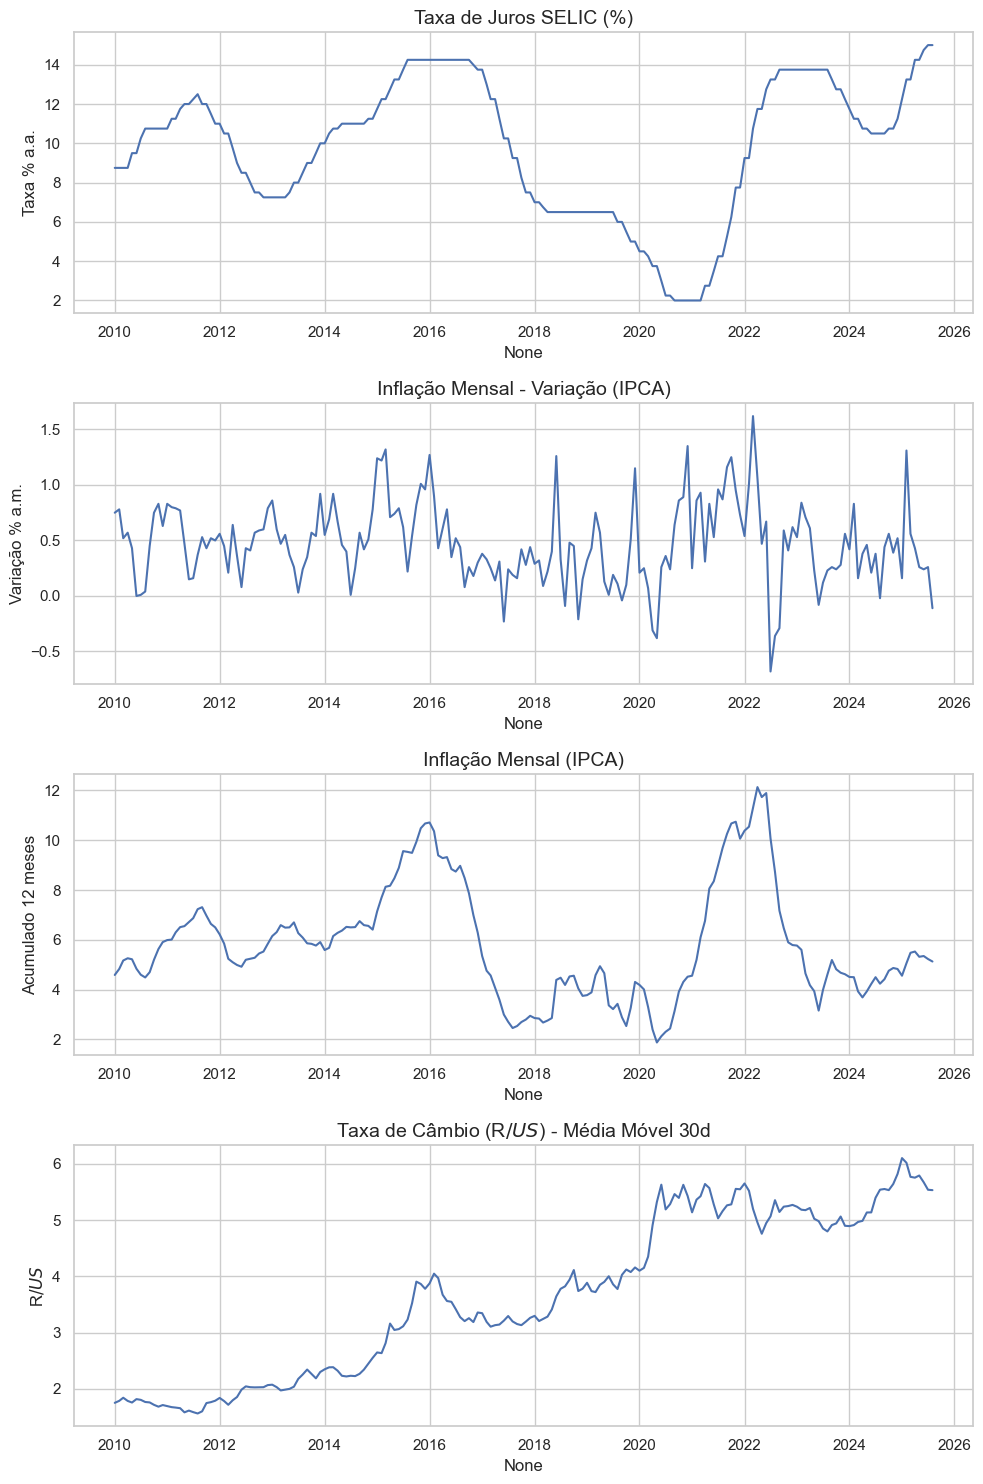

In [51]:
# 1. Criamos a estrutura: uma figura (fig) com 4 eixos (axes) empilhados verticalmente
#    figsize=(10, 15) define o tamanho total da tela (largura, altura)
fig, axes = plt.subplots(nrows=4, ncols=1, figsize=(10, 15))

# 2. Desenhamos em cada eixo individualmente usando Seaborn

# Gráfico 1: SELIC (no primeiro eixo, axes[0])
sns.lineplot(data=df_macro_bcb_final, x=df_macro_bcb_final.index, y='SELIC', ax=axes[0])
axes[0].set_title('Taxa de Juros SELIC (%)', fontsize=14)
axes[0].set_ylabel('Taxa % a.a.')

# Gráfico 2: IPCA (no segundo eixo, axes[1])
sns.lineplot(data=df_macro_bcb_final, x=df_macro_bcb_final.index, y='IPCA_variacao', ax=axes[1])
axes[1].set_title('Inflação Mensal - Variação (IPCA)', fontsize=14)
axes[1].set_ylabel('Variação % a.m.')

# Gráfico 3: IPCA (no terceiro eixo, axes[2])
sns.lineplot(data=df_macro_bcb_final, x=df_macro_bcb_final.index, y='IPCA', ax=axes[2])
axes[2].set_title('Inflação Mensal (IPCA)', fontsize=14)
axes[2].set_ylabel('Acumulado 12 meses')


# Gráfico 3: Câmbio (no quarto eixo, axes[3])
sns.lineplot(data=df_macro_bcb_final, x=df_macro_bcb_final.index, y='Cambio_MM30', ax=axes[3])
axes[3].set_title('Taxa de Câmbio (R$/US$) - Média Móvel 30d', fontsize=14)
axes[3].set_ylabel('R$ / US$')


# 3. Ajusta o layout para evitar sobreposição de títulos e eixos
plt.tight_layout()

# 4. Mostra os gráficos
plt.show()

Vamos criar uma variável que nos dá a decisão do COPOM naquele mês e compará-la diretamente com a variação mensal do IPCA.df_macro_bcb_final

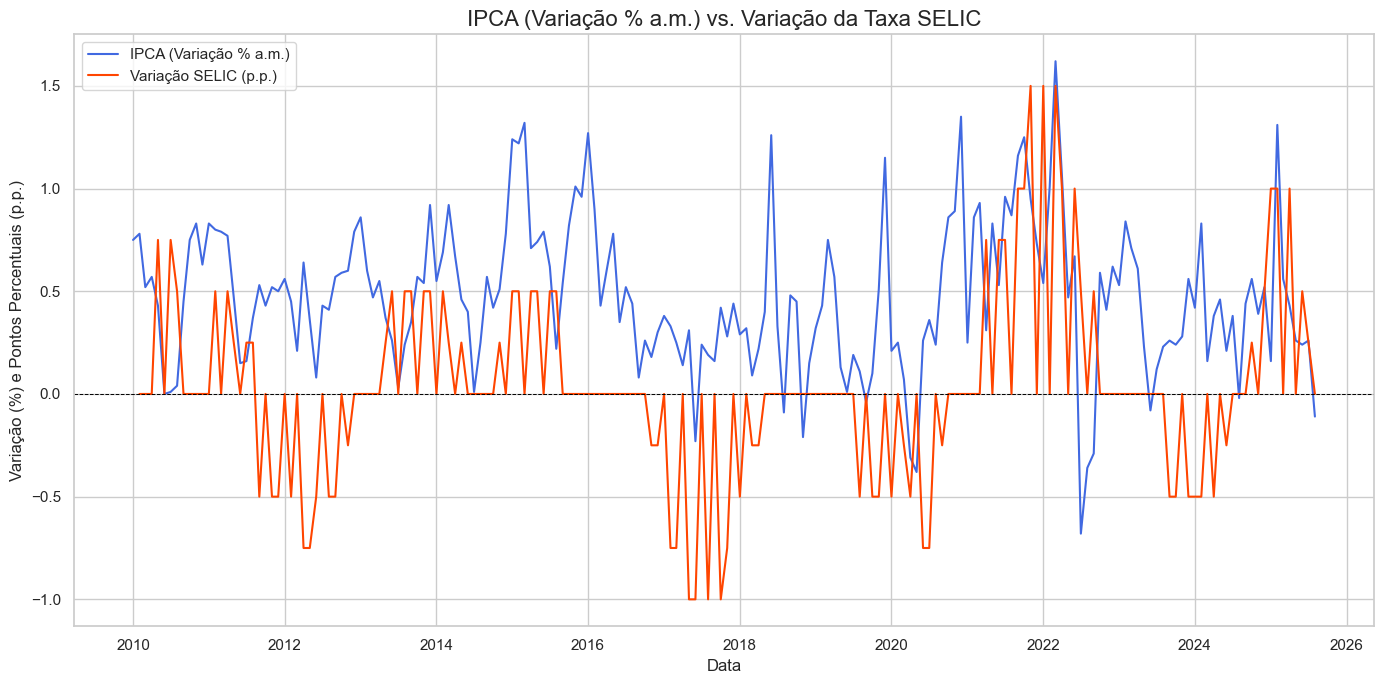

In [56]:
#Criando a variável SELIC VARIAÇÃO direto no DataFrame a partir da transformação da Série SELIC
df_macro_bcb_final['SELIC_VARIACAO']=df_macro_bcb_final['SELIC'].diff()



# 1. Criamos a figura e um único eixo (ax)
fig, ax = plt.subplots(figsize=(14, 7))

# 2. Plotamos a série IPCA no eixo 'ax'
sns.lineplot(
    data=df_macro_bcb_final,
    x=df_macro_bcb_final.index,
    y='IPCA_variacao',
    ax=ax,
    label='IPCA (Variação % a.m.)', # Label para a legenda
    color='royalblue'
)

# 3. Plotamos a série SELIC_VARIAÇÃO no MESMO eixo 'ax'
sns.lineplot(
    data=df_macro_bcb_final,
    x=df_macro_bcb_final.index,
    y='SELIC_VARIACAO',
    ax=ax,
    label='Variação SELIC (p.p.)', # Label para a legenda
    color='orangered'
)

# --- Melhorias no Gráfico ---

# Adicionamos uma linha horizontal no zero para referência
ax.axhline(0, color='black', linestyle='--', linewidth=0.7)

# Adicionamos títulos e legendas
ax.set_title('IPCA (Variação % a.m.) vs. Variação da Taxa SELIC', fontsize=16)
ax.set_xlabel('Data')
ax.set_ylabel('Variação (%) e Pontos Percentuais (p.p.)')
ax.legend(loc='upper left') # Mostra a legenda, localizando no canto superior esquerdo

plt.tight_layout()
plt.show()

Outra coisa possivelmente interessante é avaliar se há alguma correlação entre variações no câmbio e decisões do COPOM - como usualmente assume-se. Dessa forma, vamos criar taxa de variação mensal do câmbio e compará-la à variações na SELIC.

In [53]:
df_macro_bcb_final.info

#Calculando a variação percentual do cambio:
df_macro_bcb_final['CAMBIO_VARIACAO']=df_macro_bcb_final['Cambio_MM30'].pct_change()*100

#Analisando o resultado:
print("Dados com a nova coluna CAMBIO_VARIACAO (últimas 5 linhas):")
print(df_macro_bcb_final.tail())

Dados com a nova coluna CAMBIO_VARIACAO (últimas 5 linhas):
            SELIC  IPCA  IPCA_variacao  Cambio_MM30  CAMBIO_VARIACAO
2025-04-01  14.25  5.53           0.43     5.753123        -0.249501
2025-05-01  14.25  5.32           0.26     5.790827         0.655354
2025-06-01  14.75  5.35           0.24     5.671517        -2.060328
2025-07-01  15.00  5.23           0.26     5.538103        -2.352340
2025-08-01  15.00  5.13          -0.11     5.531247        -0.123809


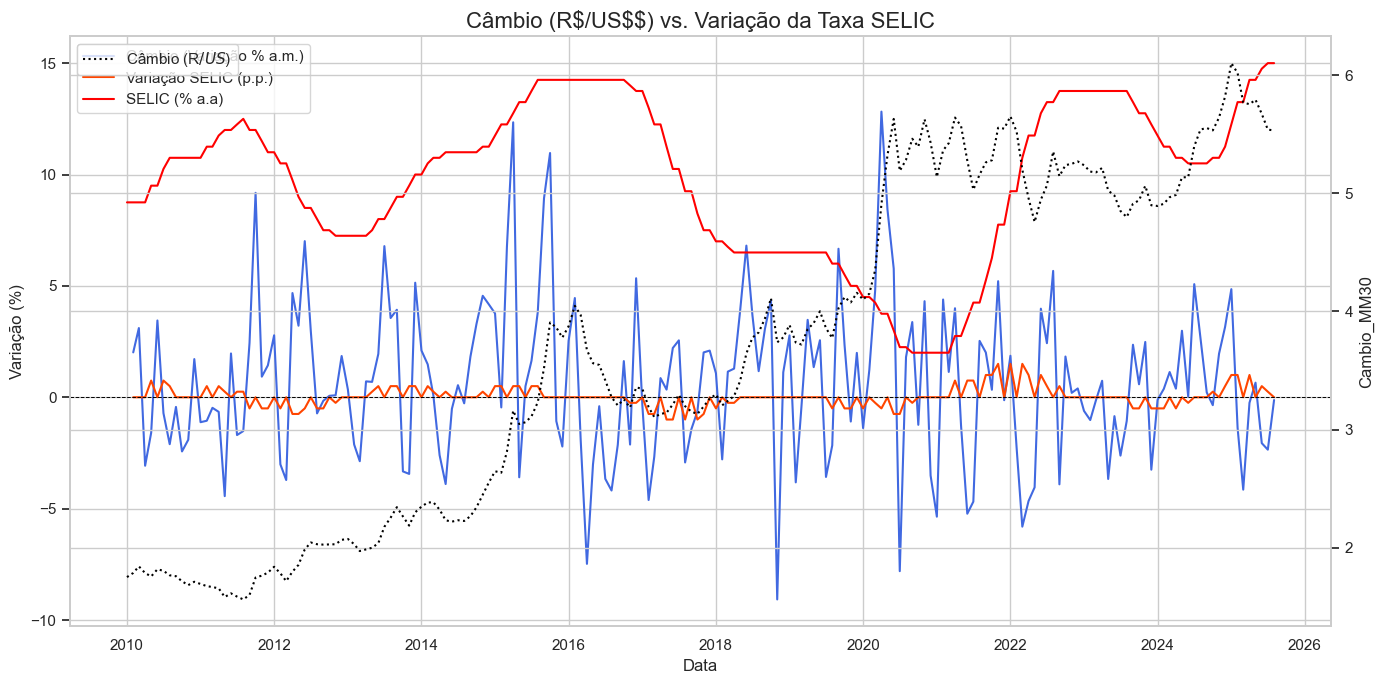

In [57]:

# 1. Criamos a figura e um único eixo (ax)
fig, ax = plt.subplots(figsize=(14, 7))

# 2. Plotamos a série CAMBIO_VARIACAO no eixo 'ax'
sns.lineplot(
    data=df_macro_bcb_final,
    x=df_macro_bcb_final.index,
    y='CAMBIO_VARIACAO',
    ax=ax,
    label='Câmbio (Variação % a.m.)', # Label para a legenda
    color='royalblue'
)

# 3. Plotamos a série SELIC_VARIAÇÃO no MESMO eixo 'ax'
sns.lineplot(
    data=df_macro_bcb_final,
    x=df_macro_bcb_final.index,
    y='SELIC_VARIACAO',
    ax=ax,
    label='Variação SELIC (p.p.)', # Label para a legenda
    color='orangered'
)

# 4. Plotamos a série SELIC no MESMO eixo 'ax'
sns.lineplot(
    data=df_macro_bcb_final,
    x=df_macro_bcb_final.index,
    y='SELIC',
    ax=ax,
    label='SELIC (% a.a)', # Label para a legenda
    color='red'
)

#5. Plotando a série CAMBIO_mm30 no eixo direito
ax2=ax.twinx()

sns.lineplot(
    data=df_macro_bcb_final,
    x=df_macro_bcb_final.index,
    y='Cambio_MM30',
    ax=ax2,
    label='Câmbio (R$/US$)', # Label para a legenda
    color='black',
    linestyle=':',
)


# --- Melhorias no Gráfico ---

# Adicionamos uma linha horizontal no zero para referência
ax.axhline(0, color='black', linestyle='--', linewidth=0.7)

# Adicionamos títulos e legendas
ax.set_title('Câmbio (R$/US$$) vs. Variação da Taxa SELIC', fontsize=16)
ax.set_xlabel('Data')
ax.set_ylabel('Variação (%)')
ax.legend(loc='upper left') # Mostra a legenda, localizando no canto superior esquerdo

plt.tight_layout()
plt.show()

Podemos também criar uma tabela de correlação cruzada entre as taxas de variações dessas variáveis, ajudando-nos a visualizar a relação entre elas. 

In [62]:
# 1. Selecionamos apenas as colunas de VARIAÇÃO que queremos analisar
#    Usamos .dropna() para garantir que não há buracos que afetem o cálculo
df_variacoes = df_macro_bcb_final[['IPCA_variacao', 'SELIC_VARIACAO', 'CAMBIO_VARIACAO']].dropna()

# 2. Calculamos a matriz de correlação
matriz_corr = df_variacoes.corr()

# 3. Exibimos a matriz numérica
print("--- Matriz de Correlação Numérica ---")
print(matriz_corr)

--- Matriz de Correlação Numérica ---
                 IPCA_variacao  SELIC_VARIACAO  CAMBIO_VARIACAO
IPCA_variacao         1.000000        0.294019        -0.073378
SELIC_VARIACAO        0.294019        1.000000        -0.020221
CAMBIO_VARIACAO      -0.073378       -0.020221         1.000000


A correlação entre IPCA e SELIC é a mais forte - o que é amplamente respaldado pela teoria econômica. A SELIC é o instrumento de política monetária que o Banco Central do Brasil usa para controlar a inflação - comumente medida pelo IPCA. Já a correlação entre as outras variáveis não é muito forte e está sem os devidos controles: o câmbio é afetado pelo cenário internacional (como diferença de juros entre Brasil e EUA), pela política interna, por conflitos internacionais. Assim, a SELIC unicamente não é uma boa ferramente para analisar movimentos cambiais. Assim, a correlação câmbio - IPCA e câmbio - SELIC são fracas. Além disso, a correlação câmbio - IPCA possui sinal trocado.

Aumentos do câmbio - ou seja, uma desvalorização do real - tende a aumentar preços de insumos importados - como combustíveis - o que tende a afetar toda a cadeia de produção, encarecendo bens consumidos pelo Brasil e, consequentemente, aumentando a taxa de inflação. 

Algo similar ocorre com a SELIC - aumentos da taxa básica de juros da economia brasileira tenderia a fortalecer o real - aumenta-se o prêmio dos títulos públicos brasileiros frente ao de outras economias, levando a um aumento da demanda pela moeda brasileira e uma maior oferta de dólares no mercado doméstico, valorizando o real de desvalorizando o dólar. Assim, o sinal da correlação está correto - aumento de um correlaciona diminuição do outro - mas como o câmbio também é afetado por muitas outras variáveis, essa correlação é fraca.

Outra coisa interessante de ver é o juros real da economia - entendido aqui como a diferença entre a SELIC e o IPCA - em suas formas aproximadas ou exatas, usando a definição de Fisher.

<Axes: xlabel='None', ylabel='SELIC'>

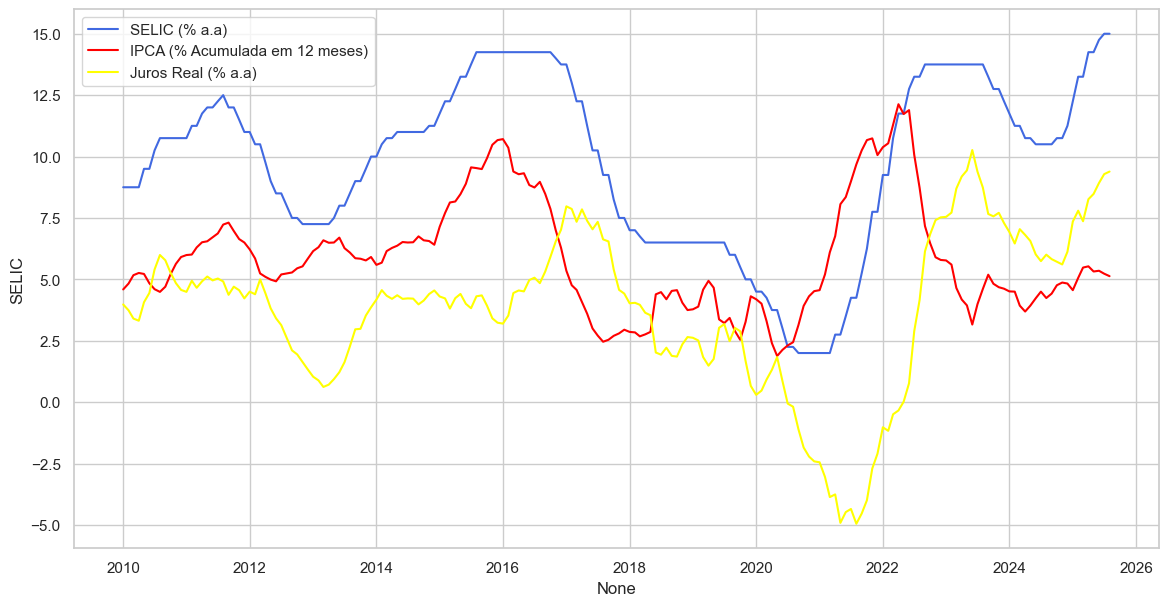

In [66]:
#Criando a variável de juros real usando a SELIC e o IPCA com a fórmula de Fisher
selic_decimal = df_macro_bcb_final['SELIC']/100
IPCA_12m_decimal = df_macro_bcb_final['IPCA']/100
juros_real_decimal = ((1 + selic_decimal)/(1+IPCA_12m_decimal)) - 1
df_macro_bcb_final['Juros_Real'] = 100*juros_real_decimal

# 1. Criamos a figura e um único eixo (ax)
fig, ax = plt.subplots(figsize=(14, 7))

#2. Plotamos a série SELIC no MESMO eixo 'ax'
sns.lineplot(
    data=df_macro_bcb_final,
    x=df_macro_bcb_final.index,
    y='SELIC',
    ax=ax,
    label='SELIC (% a.a)', # Label para a legenda
    color='royalblue'
)

# 3. Plotamos a série IPCA no MESMO eixo 'ax'
sns.lineplot(
    data=df_macro_bcb_final,
    x=df_macro_bcb_final.index,
    y='IPCA',
    ax=ax,
    label='IPCA (% Acumulada em 12 meses)', # Label para a legenda
    color='red'
)

# 4. Plotamos a série Juros Real no MESMO eixo 'ax'
sns.lineplot(
    data=df_macro_bcb_final,
    x=df_macro_bcb_final.index,
    y='Juros_Real',
    ax=ax,
    label='Juros Real (% a.a)', # Label para a legenda
    color='yellow'
)




<Axes: xlabel='None', ylabel='Juros_Real_aprox'>

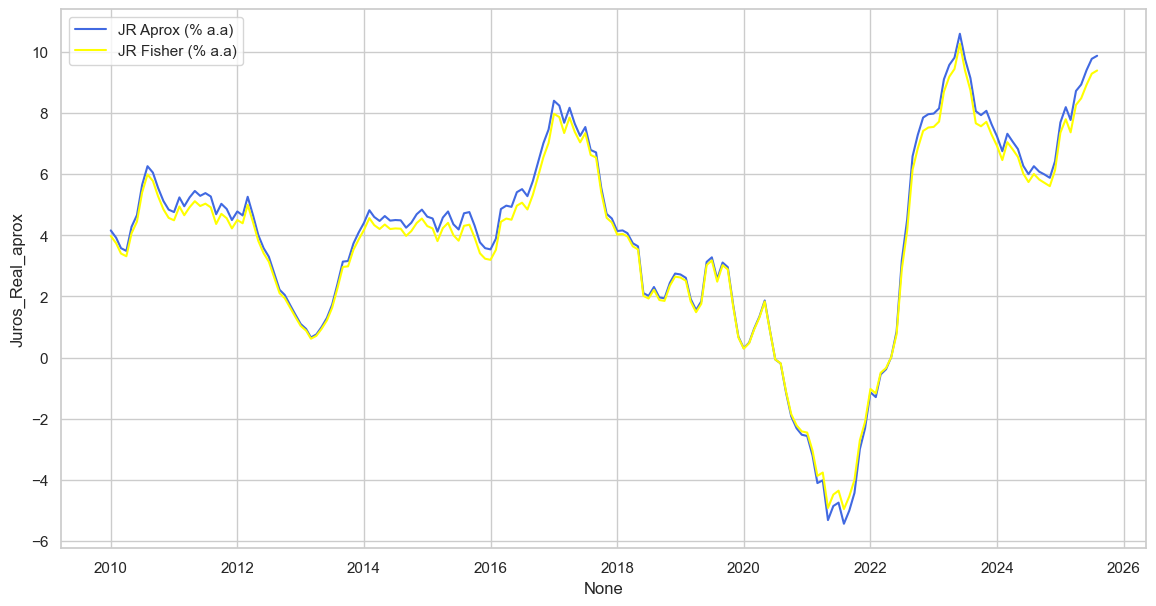

In [67]:
# 1. Criamos a figura e um único eixo (ax)
fig, ax = plt.subplots(figsize=(14, 7))

#Juros Real Aproximado via diferença entre SELIC e IPCA
df_macro_bcb_final['Juros_Real_aprox'] = df_macro_bcb_final['SELIC'] - df_macro_bcb_final['IPCA']

#2. Plotamos a série Juros Real Aprox. no MESMO eixo 'ax'
sns.lineplot(
    data=df_macro_bcb_final,
    x=df_macro_bcb_final.index,
    y='Juros_Real_aprox',
    ax=ax,
    label='JR Aprox (% a.a)', # Label para a legenda
    color='royalblue'
)

#2. Plotamos a série Juros Real no MESMO eixo 'ax'
sns.lineplot(
    data=df_macro_bcb_final,
    x=df_macro_bcb_final.index,
    y='Juros_Real',
    ax=ax,
    label='JR Fisher (% a.a)', # Label para a legenda
    color='yellow'
)


Vamos exportar os dados para o Excel para finalizar essa etapa. 

In [68]:
pip install openpyxl

Note: you may need to restart the kernel to use updated packages.


In [69]:
#Exportando os dados para Excel de maneira controlada
df_macro_bcb_final.to_excel(
    "intro_hands_on_pandas_macro_data.xlsx",  # Nome do arquivo de saída
    sheet_name='Dados Macroeconômicos',   # Nome que aparecerá na aba da planilha
    index=True,                   # Explicitamente dizemos para incluir o índice
    index_label='Data'            # Damos um título para a coluna do índice
)

print("Arquivo salvo com sucesso!")

Arquivo salvo com sucesso!
